# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [ ]:
name = ''
if name == '':
    raise NotImplementedError('Pole Murali Krishna')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [3]:
import requests
from bs4 import BeautifulSoup
import unittest


for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [1]:
import requests
from bs4 import BeautifulSoup
import unittest

def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL.

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx, 5xx)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = [a.get('href') for a in soup.find_all('a', href=True)]
        return links
    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL: {e}")
        return []

# Example usage
print(get_all_links('https://en.wikipedia.org')[:10])


['#bodyContent', '/wiki/Main_Page', '/wiki/Wikipedia:Contents', '/wiki/Portal:Current_events', '/wiki/Special:Random', '/wiki/Wikipedia:About', '//en.wikipedia.org/wiki/Wikipedia:Contact_us', '/wiki/Help:Contents', '/wiki/Help:Introduction', '/wiki/Wikipedia:Community_portal']


In [2]:
get_all_links('http://en.wikipedia.com')[:10]

['#bodyContent',
 '/wiki/Main_Page',
 '/wiki/Wikipedia:Contents',
 '/wiki/Portal:Current_events',
 '/wiki/Special:Random',
 '/wiki/Wikipedia:About',
 '//en.wikipedia.org/wiki/Wikipedia:Contact_us',
 '/wiki/Help:Contents',
 '/wiki/Help:Introduction',
 '/wiki/Wikipedia:Community_portal']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [9]:
from bs4 import BeautifulSoup
import requests

def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the HTML content of each of them.

    :param url: A string that is the URL of the webpage
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        links = [a.get('href') for a in soup.find_all('a', href=True)]
        
        for link in links:
            page_url = link
            if not page_url.startswith('http'):
                page_url = requests.compat.urljoin(url, page_url)
            try:
                page_response = requests.get(page_url)
                page_response.raise_for_status()
                yield page_response.text
            except requests.exceptions.RequestException as e:
                print(f"Error fetching {page_url}: {e}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the main page {url}: {e}")


In [8]:
import unittest
from unittest.mock import patch, Mock
from bs4 import BeautifulSoup

def get_neighbor_pages(url: str):
    import requests
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = [a.get('href') for a in soup.find_all("a", href=True)]
    
    for link in links:
        page_url = link
        if not page_url.startswith('http'):
            page_url = requests.compat.urljoin(url, page_url)
        page_response = requests.get(page_url)
        yield page_response.text

class TestGetNeighborPages(unittest.TestCase):
    @patch('requests.get')
    def test_get_neighbor_pages(self, mock_get):
        mock_response_main = Mock()
        mock_response_main.status_code = 200
        mock_response_main.text = """
        <html>
            <body>
                <a href="https://example.com/page1">Page 1</a>
                <a href="https://example.com/page2">Page 2</a>
            </body>
        </html>
        """

        mock_response_page1 = Mock()
        mock_response_page1.status_code = 200
        mock_response_page1.text = "<html><body>Content of Page 1</body></html>"

        mock_response_page2 = Mock()
        mock_response_page2.status_code = 200
        mock_response_page2.text = "<html><body>Content of Page 2</body></html>"

        def side_effect(url):
            if url == "https://example.com":
                return mock_response_main
            elif url == "https://example.com/page1":
                return mock_response_page1
            elif url == "https://example.com/page2":
                return mock_response_page2

        mock_get.side_effect = side_effect
        
        pages = list(get_neighbor_pages("https://example.com"))
        self.assertEqual(len(pages), 2)
        self.assertIn("Content of Page 1", pages[0])
        self.assertIn("Content of Page 2", pages[1])

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

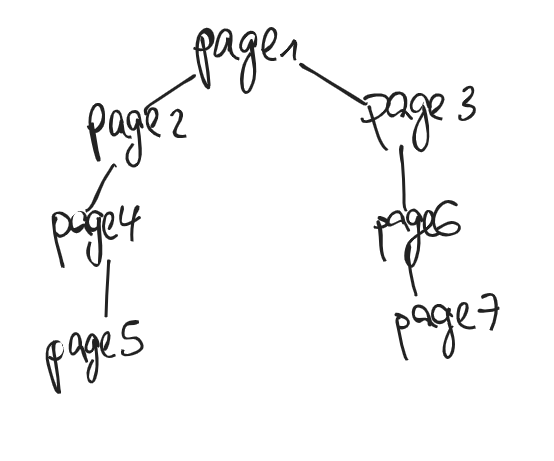

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [23]:
import requests
from bs4 import BeautifulSoup
from functools import wraps

def handle_duplicates(func):
    @wraps(func)
    def wrapper(url, depth, visited=None):
        if visited is None:
            visited = set()
        return func(url, depth, visited)
    return wrapper

@handle_duplicates
def get_pages_depth(url: str, depth: int, visited: set):
    """
    Go as deep as the given depth through the links in the webpage at the given URL
    and yield the HTML content of each of them.

    :param url: A string that is the URL of the webpage
    :param depth: An integer that is the depth until which the function searches
    """
    if depth < 0:
        return
    if url in visited:
        return
    visited.add(url)
    try:
        response = requests.get(url)
        response.raise_for_status()
        yield response.text
        if depth > 0:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = [a.get('href') for a in soup.find_all('a', href=True)]
            for link in links:
                if not link.startswith('http'):
                    link = requests.compat.urljoin(url, link)
                yield from get_pages_depth(link, depth - 1, visited)
    except requests.RequestException as e:
        print(f"Error fetching URL: {e}")

print("function get_pages_depth is ready to use.")


function get_pages_depth is ready to use.


In [24]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [25]:
print(next(pages))

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>Wikipedia, the free encyclopedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled

In [26]:
import unittest
from unittest.mock import patch, Mock
from bs4 import BeautifulSoup

class TestGetPagesDepth(unittest.TestCase):
    @patch('requests.get')
    def test_get_pages_depth(self, mock_get):
        mock_response_main = Mock()
        mock_response_main.status_code = 200
        mock_response_main.text = """
        <html>
            <body>
                <a href="https://example.com/page1">Page 1</a>
                <a href="https://example.com/page2">Page 2</a>
            </body>
        </html>
        """
        mock_response_page1 = Mock()
        mock_response_page1.status_code = 200
        mock_response_page1.text = "<html><body>Content of Page 1</body></html>"

        mock_response_page2 = Mock()
        mock_response_page2.status_code = 200
        mock_response_page2.text = "<html><body>Content of Page 2</body></html>"

        def side_effect(url):
            if url == "https://example.com":
                return mock_response_main
            elif url == "https://example.com/page1":
                return mock_response_page1
            elif url == "https://example.com/page2":
                return mock_response_page2

        mock_get.side_effect = side_effect
        
        pages = list(get_pages_depth("https://example.com", depth=1))
        self.assertEqual(len(pages), 3)
        self.assertIn("Content of Page 1", pages[1])
        self.assertIn("Content of Page 2", pages[2])
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [18]:
class ComputerScientist:
    def __init__(self, name, birthdate, major_achievements, alma_mater, nationality, notable_works):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater
        self.nationality = nationality
        self.notable_works = notable_works

    def __repr__(self):
        return (f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, "
                f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater}, "
                f"nationality={self.nationality}, notable_works={self.notable_works})")

    def get_summary(self):
        return (f"{self.name}, born on {self.birthdate}, is a {self.nationality} computer scientist known for {self.major_achievements}. "
                f"Educated at {self.alma_mater}, {self.name} has contributed significantly to the field through works like {self.notable_works}.")


In [19]:
import unittest

class TestComputerScientist(unittest.TestCase):

    def setUp(self):
        self.cs = ComputerScientist(
            name="Ada Lovelace",
            birthdate="10 December 1815",
            major_achievements="First algorithm intended to be processed by a machine",
            alma_mater="N/A",
            nationality="British",
            notable_works="Analytical Engine algorithm"
        )

    def test_repr(self):
        repr_str = repr(self.cs)
        self.assertIn("Ada Lovelace", repr_str)
        self.assertIn("First algorithm", repr_str)

    def test_get_summary(self):
        summary = self.cs.get_summary()
        self.assertIn("Ada Lovelace", summary)
        self.assertIn("British", summary)

def run_tests():
    suite = unittest.TestSuite()
    suite.addTest(unittest.TestLoader().loadTestsFromTestCase(TestComputerScientist))
    runner = unittest.TextTestRunner()
    runner.run(suite)

if __name__ == '__main__':
    run_tests()


..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


In [26]:
import random
import requests
from bs4 import BeautifulSoup

class ComputerScientist:
    def __init__(self, name, birthdate, major_achievements, alma_mater, nationality, notable_works):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater
        self.nationality = nationality
        self.notable_works = notable_works

    def __repr__(self):
        return (f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, "
                f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater}, "
                f"nationality={self.nationality}, notable_works={self.notable_works})")

    def get_summary(self):
        return (f"{self.name}, born on {self.birthdate}, is a {self.nationality} computer scientist known for {self.major_achievements}. "
                f"Educated at {self.alma_mater}, {self.name} has contributed significantly to the field through works like {self.notable_works}.")

def fetch_computer_scientists(num_scientists=100):
    base_url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"
    response = requests.get(base_url)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.text, 'html.parser')
    scientist_links = soup.select('li a[href^="/wiki/"]')
    
    random.shuffle(scientist_links)
    selected_links = scientist_links[:num_scientists]
    
    computer_scientists = []
    
    for link in selected_links:
        scientist_url = f"https://en.wikipedia.org{link['href']}"
        scientist_response = requests.get(scientist_url)
        scientist_soup = BeautifulSoup(scientist_response.text, 'html.parser')
        
        name = scientist_soup.find('h1').get_text()
        
        infobox = scientist_soup.find('table', {'class': 'infobox'})
        birthdate = major_achievements = alma_mater = nationality = notable_works = "Unknown"
        
        if infobox:
            rows = infobox.find_all('tr')
            for row in rows:
                header = row.find('th')
                value = row.find('td')
                if header and value:
                    header_text = header.get_text().strip()
                    value_text = value.get_text().strip()
                    if "Born" in header_text:
                        birthdate = value_text
                    elif "Notable work" in header_text:
                        notable_works = value_text
                    elif "Alma mater" in header_text:
                        alma_mater = value_text
                    elif "Nationality" in header_text:
                        nationality = value_text
                    elif "Known for" in header_text:
                        major_achievements = value_text

        computer_scientist = ComputerScientist(
            name=name,
            birthdate=birthdate,
            major_achievements=major_achievements,
            alma_mater=alma_mater,
            nationality=nationality,
            notable_works=notable_works
        )
        computer_scientists.append(computer_scientist)
    return computer_scientists

computer_scientists = fetch_computer_scientists(99)
for scientist in computer_scientists:
    print(scientist.get_summary())


Christopher J. Date, born on (1941-01-18) January 18, 1941 (age 84)Watford, England, is a British computer scientist known for Unknown. Educated at Unknown, Christopher J. Date has contributed significantly to the field through works like Unknown.
Accessibility, born on Unknown, is a Unknown computer scientist known for Unknown. Educated at Unknown, Accessibility has contributed significantly to the field through works like Unknown.
Joel Moses, born on 25 November 1941 (1941-11-25)Mandatory Palestine, is a Unknown computer scientist known for Unknown. Educated at Unknown, Joel Moses has contributed significantly to the field through works like Unknown.
Computer network, born on Unknown, is a Unknown computer scientist known for Unknown. Educated at Unknown, Computer network has contributed significantly to the field through works like Unknown.
Héctor García-Molina, born on 26 November 1954 (1954)Monterrey, Mexico, is a Unknown computer scientist known for Unknown. Educated at Unknown, 

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [2]:
class ComputerScientist:
    def __init__(self, name, birthdate, major_achievements, alma_mater, nationality, notable_works):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater
        self.nationality = nationality
        self.notable_works = notable_works

    def __repr__(self):
        return (f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, "
                f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater}, "
                f"nationality={self.nationality}, notable_works={self.notable_works})")

    def get_summary(self):
        return (f"{self.name}, born on {self.birthdate}, is a {self.nationality} computer scientist known for {self.major_achievements}. "
                f"Educated at {self.alma_mater}, {self.name} has contributed significantly to the field through works like {self.notable_works}.")


In [3]:
import requests
from bs4 import BeautifulSoup

def fetch_scientist(name: str):
    search_url = f"https://en.wikipedia.org/wiki/{name.replace(' ', '_')}"
    response = requests.get(search_url)
    
    if response.status_code != 200:
        print(f"Scientist '{name}' does not exist on Wikipedia.")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    infobox = soup.find('table', {'class': 'infobox'})
    if not infobox:
        print(f"Could not find information for '{name}' on Wikipedia.")
        return None
    
    birthdate = major_achievements = alma_mater = nationality = notable_works = "Unknown"
    
    if infobox:
        rows = infobox.find_all('tr')
        for row in rows:
            header = row.find('th')
            value = row.find('td')
            if header and value:
                header_text = header.get_text().strip()
                value_text = value.get_text().strip()
                if "Born" in header_text:
                    birthdate = value_text
                elif "Notable work" in header_text:
                    notable_works = value_text
                elif "Alma mater" in header_text:
                    alma_mater = value_text
                elif "Nationality" in header_text:
                    nationality = value_text
                elif "Known for" in header_text:
                    major_achievements = value_text

    scientist = ComputerScientist(
        name=name,
        birthdate=birthdate,
        major_achievements=major_achievements,
        alma_mater=alma_mater,
        nationality=nationality,
        notable_works=notable_works
    )
    setattr(scientist, 'wikipedia_link', search_url)
    
    return scientist


In [4]:
from functools import lru_cache

@lru_cache(maxsize=100)
def cached_fetch_scientist(name: str):
    return fetch_scientist(name)

scientist = cached_fetch_scientist("Alan_Turing")
if scientist:
    print(scientist.get_summary())
    print(f"Wikipedia link: {scientist.wikipedia_link}")


Alan_Turing, born on Alan Mathison Turing(1912-06-23)23 June 1912Maida Vale, London, England, is a Unknown computer scientist known for Unknown. Educated at Unknown, Alan_Turing has contributed significantly to the field through works like Unknown.
Wikipedia link: https://en.wikipedia.org/wiki/Alan_Turing


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

Scientist 'Alan Turing' added successfully.
Scientist 'Ada Lovelace' is already in the graph.
Scientist 'Grace Hopper' is already in the graph.


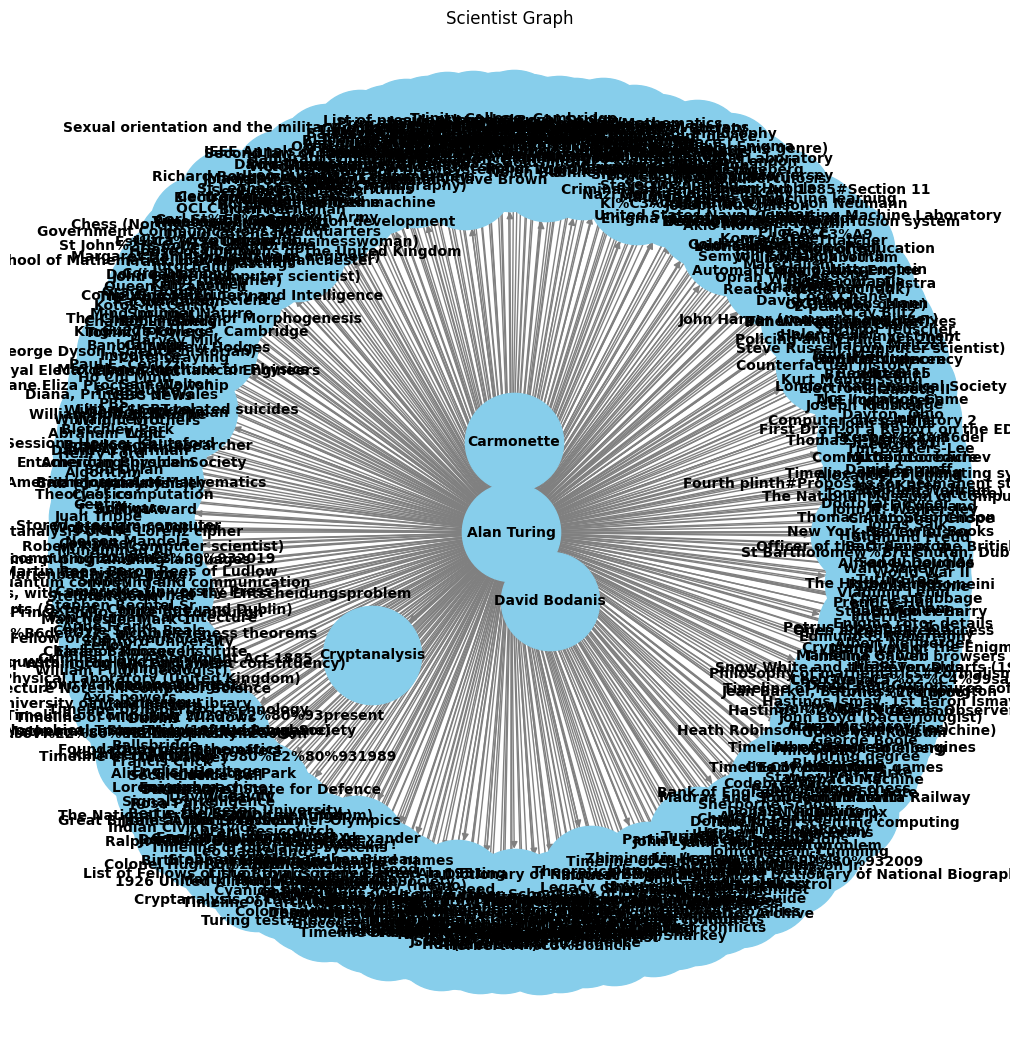

Ranked Scientists: [('Alan Turing', 0.001612903225806437), ('Main Page', 0.001612903225806437), ('Turing (disambiguation)', 0.001612903225806437), ('Officer of the Order of the British Empire', 0.001612903225806437), ('Fellow of the Royal Society', 0.001612903225806437), ('Maida Vale', 0.001612903225806437), ('Wilmslow', 0.001612903225806437), ('Cyanide poisoning', 0.001612903225806437), ('Suicide', 0.001612903225806437), ('University of Cambridge', 0.001612903225806437), ('Bachelor of Arts', 0.001612903225806437), ('Master of Arts (Oxford, Cambridge, and Dublin)', 0.001612903225806437), ('Princeton University', 0.001612903225806437), ('Doctor of Philosophy', 0.001612903225806437), ('Cryptanalysis of the Enigma', 0.001612903225806437), ('Turing%27s proof', 0.001612903225806437), ('Turing machine', 0.001612903225806437), ('Turing test', 0.001612903225806437), ('Unorganized machine', 0.001612903225806437), ('Turing pattern', 0.001612903225806437), ('Turing reduction', 0.00161290322580643

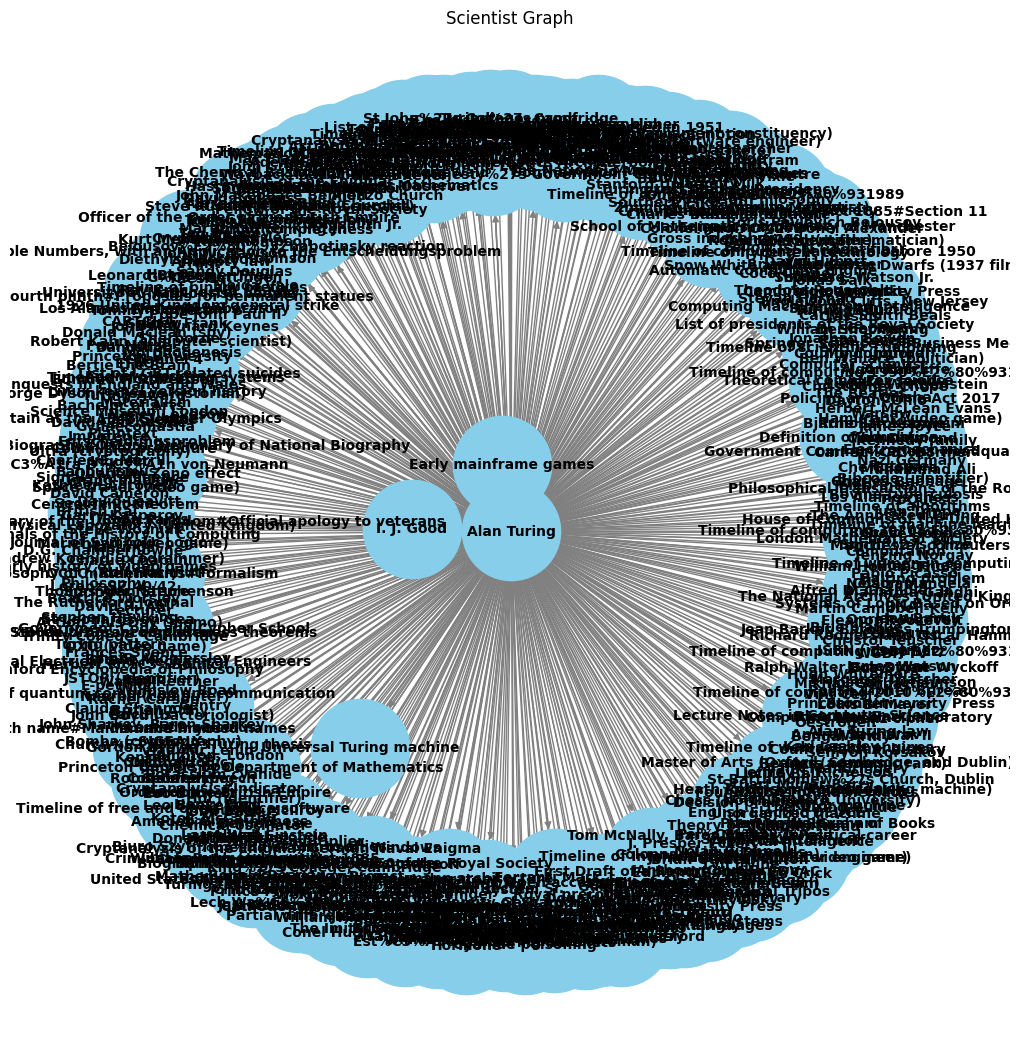

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache
import requests
from bs4 import BeautifulSoup

class ComputerScientist:
    def __init__(self, name, birthdate, major_achievements, alma_mater, nationality, notable_works):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater
        self.nationality = nationality
        self.notable_works = notable_works

    def __repr__(self):
        return (f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, "
                f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater}, "
                f"nationality={self.nationality}, notable_works={self.notable_works})")

    def get_summary(self):
        return (f"{self.name}, born on {self.birthdate}, is a {self.nationality} computer scientist known for {self.major_achievements}. "
                f"Educated at {self.alma_mater}, {self.name} has contributed significantly to the field through works like {self.notable_works}.")

@lru_cache(maxsize=100)
def cached_fetch_scientist(name: str):
    search_url = f"https://en.wikipedia.org/wiki/{name.replace(' ', '_')}"
    response = requests.get(search_url)
    
    if response.status_code != 200:
        print(f"Scientist '{name}' does not exist on Wikipedia.")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    infobox = soup.find('table', {'class': 'infobox'})
    if not infobox:
        print(f"Could not find information for '{name}' on Wikipedia.")
        return None
    
    birthdate = major_achievements = alma_mater = nationality = notable_works = "Unknown"
    
    if infobox:
        rows = infobox.find_all('tr')
        for row in rows:
            header = row.find('th')
            value = row.find('td')
            if header and value:
                header_text = header.get_text().strip()
                value_text = value.get_text().strip()
                if "Born" in header_text:
                    birthdate = value_text
                elif "Notable work" in header_text:
                    notable_works = value_text
                elif "Alma mater" in header_text:
                    alma_mater = value_text
                elif "Nationality" in header_text:
                    nationality = value_text
                elif "Known for" in header_text:
                    major_achievements = value_text

    scientist = ComputerScientist(
        name=name,
        birthdate=birthdate,
        major_achievements=major_achievements,
        alma_mater=alma_mater,
        nationality=nationality,
        notable_works=notable_works
    )
    setattr(scientist, 'wikipedia_link', search_url)
    
    return scientist

class ScientistGraph:
    def __init__(self):
        self.scientist_list = []
        self.graph = nx.DiGraph()

    def add_scientist(self, scientist_name: str):
        scientist = cached_fetch_scientist(scientist_name)
        if scientist is None:
            print(f"Scientist '{scientist_name}' could not be fetched.")
            return
        
        if scientist_name in self.graph:
            print(f"Scientist '{scientist_name}' is already in the graph.")
            return

        self.scientist_list.append(scientist)
        self.graph.add_node(scientist_name, scientist=scientist)

]        response = requests.get(scientist.wikipedia_link)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = [a.get('href') for a in soup.find_all('a', href=True)]
            for link in links:
                if link.startswith('/wiki/') and not ':' in link:
                    target_name = link.split('/wiki/')[1].replace('_', ' ')
                    self.graph.add_edge(scientist_name, target_name)
        print(f"Scientist '{scientist_name}' added successfully.")

    def remove_scientist(self, scientist_name: str):
        if scientist_name not in self.graph:
            print(f"Scientist '{scientist_name}' is not in the graph.")
            return
        
        self.graph.remove_node(scientist_name)
        self.scientist_list = [s for s in self.scientist_list if s.name != scientist_name]
        print(f"Scientist '{scientist_name}' removed successfully.")

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray')
        plt.title("Scientist Graph")
        plt.show()

    def rank_scientists(self):
        page_rank = nx.pagerank(self.graph)
        ranked_scientists = sorted(page_rank.items(), key=lambda item: item[1], reverse=True)
        return ranked_scientists

sg = ScientistGraph()
sg.add_scientist("Alan Turing")
sg.add_scientist("Ada Lovelace")
sg.add_scientist("Grace Hopper")
sg.plot()
ranked_scientists = sg.rank_scientists()
print("Ranked Scientists:", ranked_scientists)
sg.remove_scientist("Ada Lovelace")
sg.plot()
